In [1]:
%config InlineBackend.figure_formats = {"retina", "png"} # Mostar imágenes formato png y con alta resolución
# Las graficas se muestren en el notebook y no en una ventana emergente
%matplotlib inline

import os # Crea carpetas o rutas
import tempfile # Crea archivos o carpetas temporales que se eliminan automaticamente
from typing import List, Tuple # Anotaciones de tipo (mejora legibilidad y depuración del código)

os.environ["OPENBLAS_NUM_THREADS"] = "1" # Limita el numero de hilos1 a 1. Evita que el código use muchos nucleos y sobrecargue el sistema

# CREAR ANIMACIONES
from IPython.display import HTML, display
# display(): Muestra gráficos, animaciones, html, widgets, etc
# HTML(): Permite inscrustar código HTML directamente en la celda (para mostrar una animación)
import h5py # Lee y escribe archivos .h5, los cuales almacenan una gran cantidad de datos
from tdgl.visualization.animate import create_animation


import numpy as np
import matplotlib as mpl
from matplotlib.path import Path # Define curvas o contornos personalizados
from matplotlib.textpath import TextPath # Convierte texto en trayectorias gráficas (crea letras como curvas)
from matplotlib.font_manager import FontProperties # Permite usar fuentes específicas
import matplotlib.pyplot as plt

# CONFIGURACION DE ESTILO GRÁFICO
plt.rcParams["figure.figsize"] = (5, 4) # Tamaño de las figuras (ancho, alto)
plt.rcParams["font.size"] = 11 # Tamaño de la letra en las gráficas

# PAQUETE TDGL
import tdgl
from tdgl.geometry import box, circle, ensure_unique, close_curve
# box: Crea una caja (dominio rectangular) para la simulación
# ensure_unique: Asegura que los puntos de una curva no se repitan (importante en mallas)
# close_curve: Cierra una curva suavemente (para trayectorias cerradas como letras)
from tdgl.sources import LinearRamp, ConstantField
# LinearRamp: Campo magnetico que aumenta linealmente con el tiempo
# ConstanteField: Campo magnético constante

# PARÁMETROS DE EJECUCIÓN
USE_TEMPDIR = True # Se usará un directorio temporal para guardar imágenes si es TRUE
SAVE = True # Se guardarán las imágnes que se generen
MAKE_ANIMATIONS = True # Genera animaciones de la evolución del sistema
image_path = os.path.join(os.pardir, "images") # Define el path donde se guardarán las imágenes. os.pardir significa “directorio padre”, así que esto apunta a ../images

In [2]:
if USE_TEMPDIR:
    tempdir = tempfile.TemporaryDirectory()
    output_path = tempdir.name
else:
    output_path = "."

# Función para generar un video HTML a partir de una solución TDGL previamente simulada

In [3]:
def make_video_from_solution(
    solution,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)

# Defining the device (GEOMETRÍA Y PROPIEDADES DEL SISTEMA)

In [4]:
length_units = "um" # Longitud en micrómetros

# PARÁMETROS DEL MATERIAL
xi = 0.5 # Longitud de coherencia GL
london_lambda = 2 # Longitud de penetración de London \lambda
d = 0.1 # Espesor de la película semiconductora en micrómetros
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1) # Se crea el objeto "layer" que describe el material
# gamma = 1 -> Parámetro proporcional al inelastic scattering time y al tamaño del gap superconductor

# ------------------------------------ GEOMETRÍA ------------------------
# Device geometry
total_width = 5 # Ancho total de la película
total_length = 5 # Largo total de la película
link_width = total_width / 3 # Ancho de un canal o cuello entre las regiones

# GEOMETRÍA DEL SUPERCONDUCTOR -> Caja rectangular
film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    .resample(401)  # Vuelve a muestrear la curva con 401 puntos para suavizar la malla
    .buffer(0)  # Ayuda a corregir imperfecciones en los bordes del polígono
)

# AGUJEROS EN LA PELÍCULA
# Agujero circular centrado arriba (20% de la longitud total)
round_hole = (
    tdgl.Polygon("round_hole", points=circle(link_width / 3))
    .translate(dy=0)
)

# TERMINALES DE CORRIENTE -> Para aplicar una corriente a travé de uno o más terminales en el dispositivo
# Terminal de corriente (como un contacto eléctrico) que se coloca arriba. Tiene el ancho del film y una altura delgada (total_length / 100)
source = (
    tdgl.Polygon("source", points=box(total_width / 100, 0.4)) # Rectángulo box(ancho, alto) -> Un poco más ancho que la película pero con altura del 1% del alto de la película
    .translate(dx=-total_length / 2)
)
# Terminal opuesto, refleja source verticalmente (yfact=-1) y renombrado como "drain"
drain = source.scale(xfact=-1).set_name("drain") # Por donde sale la corriente

#  PUNTOS DE MEDICIÓN DE VOLTAJE -> Con esto, el potencial escalar y la fase son evaluados como una función del tiempo
# Define dos puntos simétricos donde se medirá la diferencia de potencial (voltaje)
# Están ubicados sobre el eje vertical (x=0), arriba y abajo del centro de la película
probe_points = [(-2, 0), (2, 0)]

# ---------------------------MODELO DEL SUPERCONDUCTOR-------------------
# Describe la función física del dispositivo
device = tdgl.Device(
    "weak_link",
    layer=layer,
    film=film,
    holes=[round_hole],
    terminals=[source, drain],
    probe_points=probe_points,
    length_units=length_units,
)

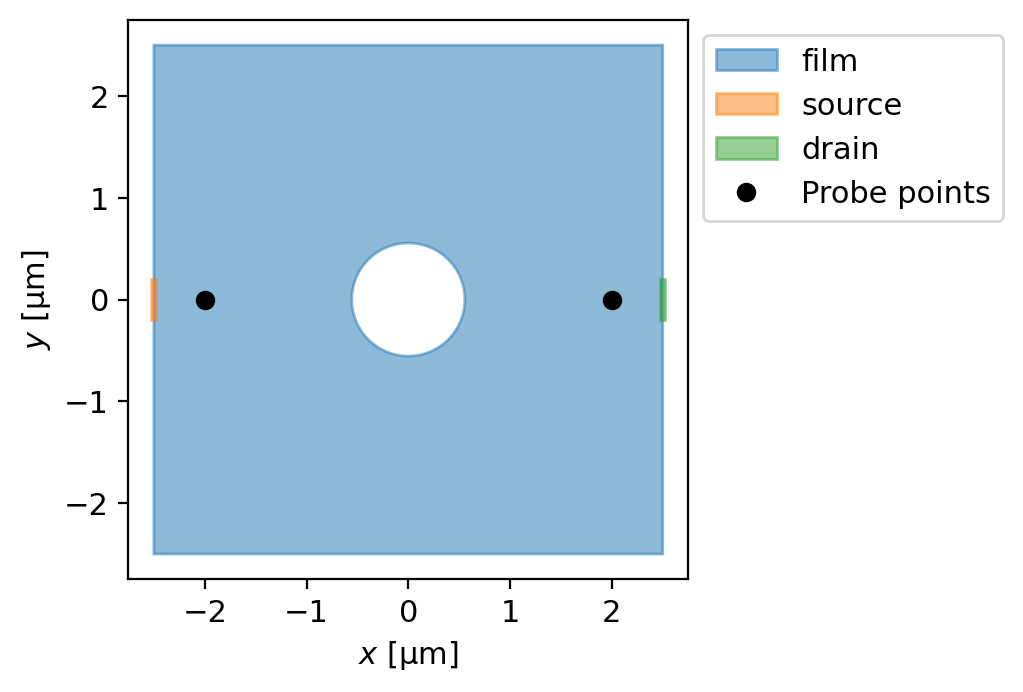

In [5]:
# Generación de la geometría del dispositivo
fig, ax = device.draw()

## Malla

Se genera la malla numérica sobre la cual se resolverá la ecuación de Ginzburg–Landau dependiente del tiempo (TDGL).

Se discretiza el dominio geométrico en pequeños elementos (triángulos o polígonos). Luego, en cada nodo (vértice) o celda se resuelve la ecuación diferencial.

Se puede especificar el número mínimo de vértices de la malla (min_points), y/o el máximo de las longitudes de los bordes (max_edge_length).

* Generalmente, los bordes en la malla deberían ser pequeños comparados con la longitud de coherencia ζ (en este caso ζ=xi=0.5)

Constructing Voronoi polygons: 100%|██████████| 2566/2566 [00:01<00:00, 1297.28it/s]


num_sites,2566
num_elements,4632
min_edge_length,2.524e-02
max_edge_length,2.332e-01
mean_edge_length,9.886e-02
min_area,3.671e-04
max_area,3.522e-02
mean_area,9.365e-03
coherence_length,5.000e-01
length_units,um


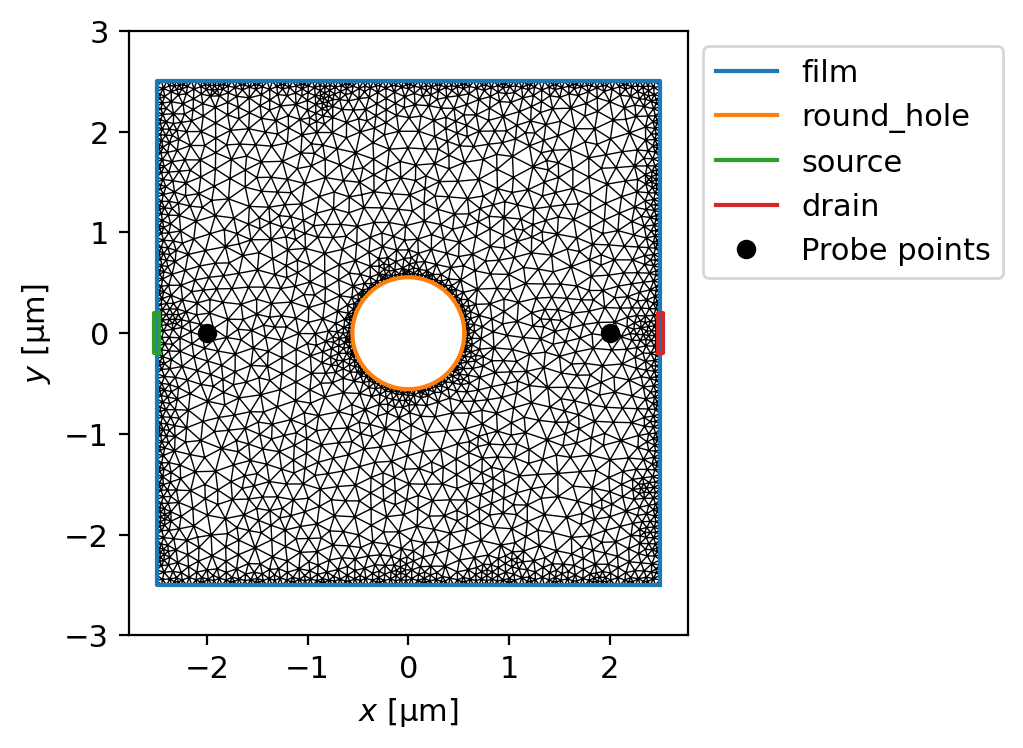

In [6]:
device.make_mesh(max_edge_length=xi / 2, smooth=100) # Genera una malla de elementos finitos que cubre el "device", la película superconductora
# smooth: Suaviza la malla, mejora la calidad geométrica de los triángulos (evita ángulos muy agudos o deformaciones). Entre mayor sea el smooth, más pasos de suavizado

# VIZUALIZAR EL DISPOSITIVO + MALLA
fig, ax = device.plot(mesh=True, legend=True)
_ = ax.set_ylim(-3, 3)  # Ajuste rangos de los ejes

device.mesh_stats() # Estadísticas de la malla (sites=nodos-vértices-, elements=triángulos)

## Simulación con campo aplicado B=0 y corriente K (eléctrica superconductora) constante

In [7]:
options = tdgl.SolverOptions(
    # Allow some time to equilibrate before saving data.
    skip_time=100,
    solve_time=150,
    output_file=os.path.join(tempdir.name, "weak-link-zero-field.h5"),
    field_units = "mT",
    current_units="uA",
    save_every=100,
)
# If you do not provide an applied_vector_potential, tdgl defaults to zero applied field.
zero_field_solution = tdgl.solve(
    device,
    options,
    # terminal_currents must satisfy current conservation, i.e.,
    # sum(terminal_currents.values()) == 0.
    terminal_currents=dict(source=12, drain=-12),  # Se aplica corriente de 12 microAmperios, sale corriente de -12 microAmperios
)

Simulating: 100%|█████████▉| 150/150 [00:20<00:00,  7.31tau/s ]


Measured current: 11.646 µA


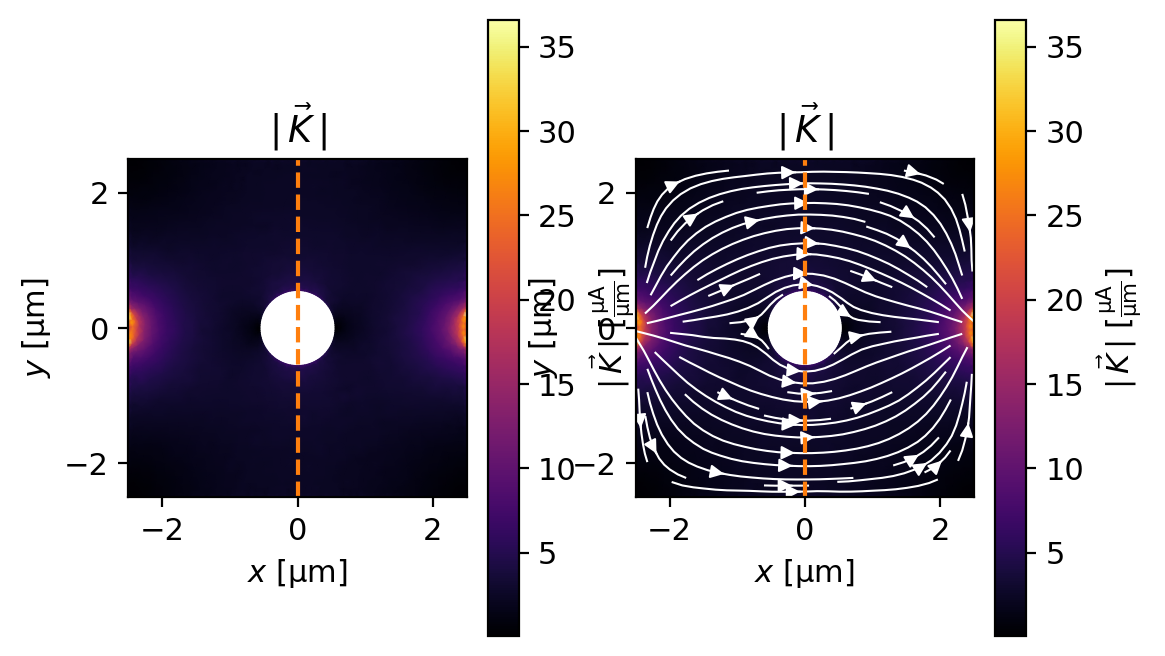

In [8]:
# GRÁFICA QUE MUESTRA LAS CORRIENTES SUPERCONDUCTORAS EN EL DISPOSITIVO
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

_ = zero_field_solution.plot_currents(ax=axes[0], streamplot=False) # axes[0]: Vectores individuales
_ = zero_field_solution.plot_currents(ax=axes[1]) # streamplot: líneas de flujo
# Define the coordinates at which to evaluate the sheet current density
y = np.linspace(-total_width / 2, total_width / 2, 401)
x = np.zeros_like(y)

cross_section = np.array([x, y]).T

# Línea de corte "cross_section" (NARANAJA) -> Acá se evalúa el flujo de corriente
for ax in axes:
    _ = ax.plot(x, y, "C1--")

# Evalúa el flujo de corriente a lo largo de la línea de corte "cross_section"
current = zero_field_solution.current_through_path(cross_section)
print(f"Measured current: {current:.3f~P}")

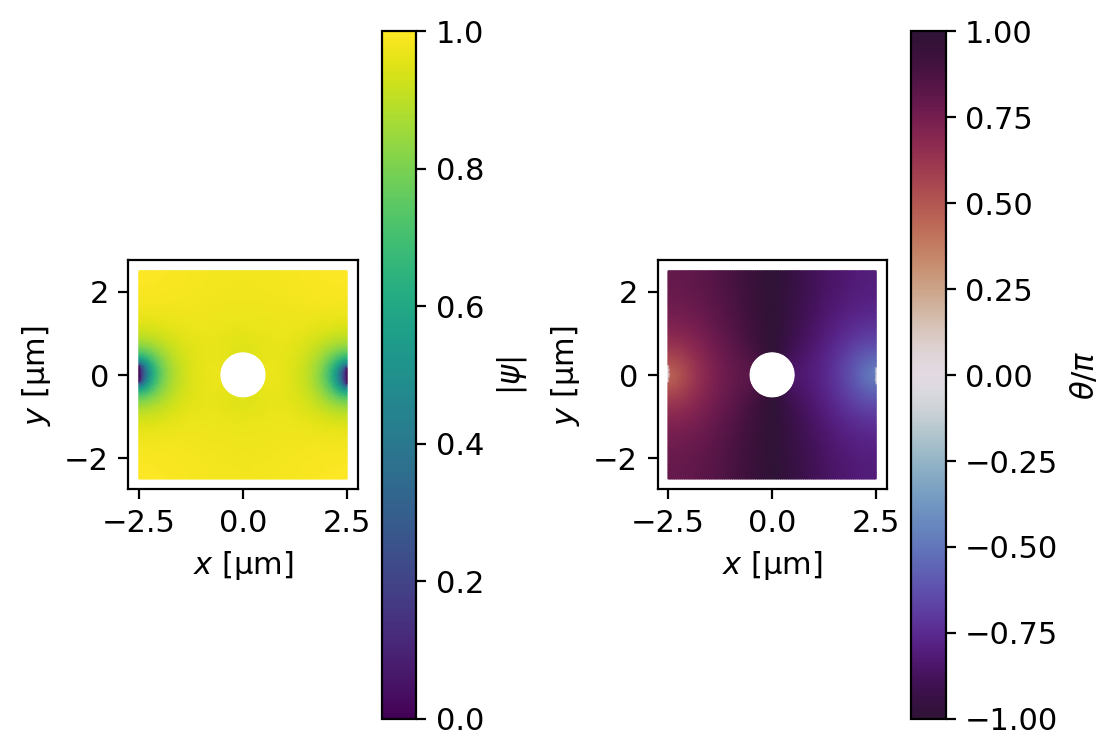

In [9]:
# Parámetro de orden ψ en un instante específico -> t = 112
# Plot a snapshot of the order parameter in the middle of a phase slip
t0 = 112
zero_field_solution.solve_step = zero_field_solution.closest_solve_step(t0)
fig, axes = zero_field_solution.plot_order_parameter(figsize=(5.5, 4))

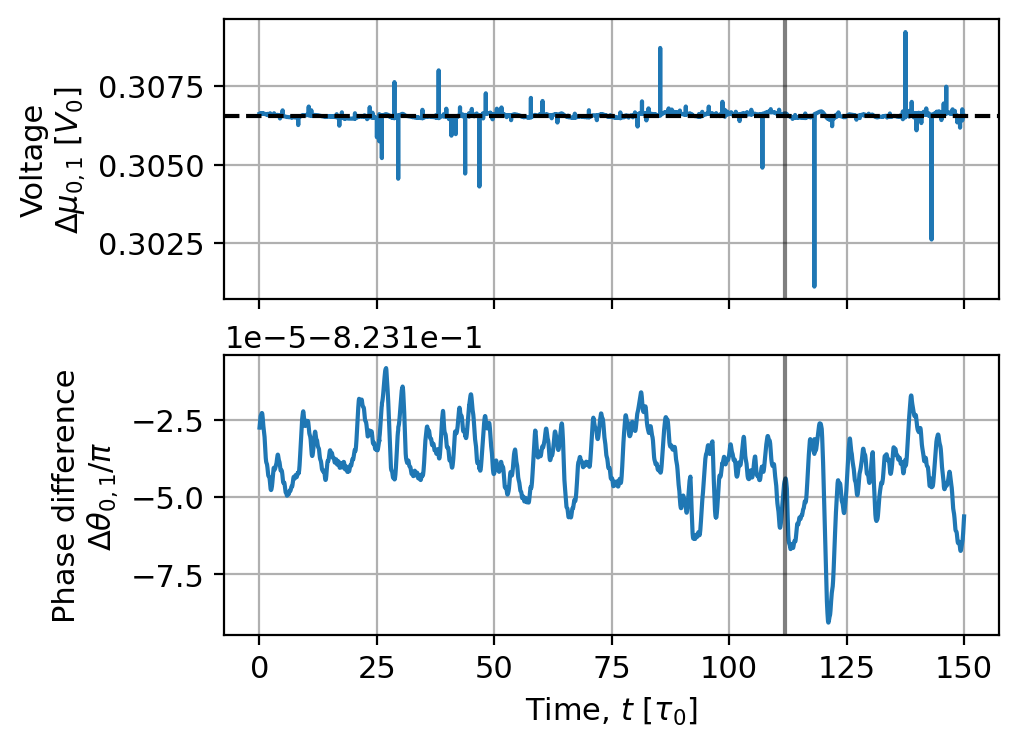

In [10]:
# Cosas de voltaje y diferencia de fase???
fig, axes = zero_field_solution.dynamics.plot()
for ax in axes:
    ax.axvline(t0, color="k", alpha=0.5)

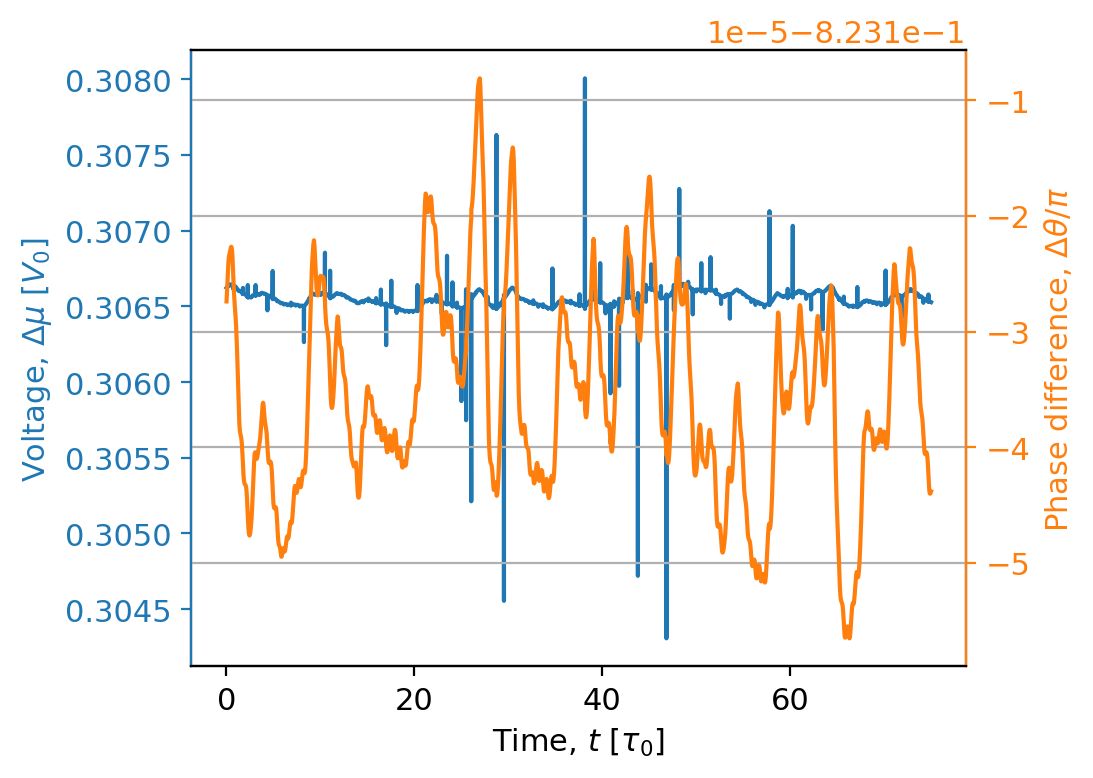

In [11]:
# Cosas de voltaje y diferencia de fase???
dynamics = zero_field_solution.dynamics
indices = dynamics.time_slice(tmax=75)

fig, ax = plt.subplots()
# Plot the voltage on the left y axis
ax.plot(dynamics.time[indices], dynamics.voltage()[indices], "C0-")
ax.tick_params(axis="y", color="C0", labelcolor="C0")
ax.set_ylabel("Voltage, $\\Delta\\mu$ [$V_0$]", color="C0")
ax.set_xlabel("Time, $t$ [$\\tau_0$]")

# Plot the phase difference on the right y axis
bx = ax.twinx()
unwrapped_phase = np.unwrap(dynamics.phase_difference()[indices])
bx.plot(dynamics.time[indices], unwrapped_phase / np.pi, "C1")
bx.grid(axis="both")
bx.spines["right"].set_color("C1")
bx.spines["left"].set_color("C0")
bx.tick_params(axis="y", color="C1", labelcolor="C1")
_ = bx.set_ylabel("Phase difference, $\\Delta\\theta/\\pi$", color="C1")

In [ ]:
# GENERA ANIMACIÓN
if MAKE_ANIMATIONS:
    zero_field_video = make_video_from_solution(
        zero_field_solution,
        quantities=["order_parameter", "phase", "scalar_potential"],
        figsize=(14, 4),
    )
    display(zero_field_video)

## Simulación de vórtices con corriente K = 0

In [13]:
options = tdgl.SolverOptions(
    solve_time=200,
    output_file=os.path.join(tempdir.name, "weak-link-zero-current.h5"),
    field_units = "mT",
    current_units="uA",
)

RAMP_FIELD = True  # El campo se aplica como una rampa (en este caso, de manera lineal en el tiempo)

if RAMP_FIELD:
    from tdgl.sources import LinearRamp, ConstantField

    # Ramp the applied field from 0 to 0.4 mT between t=0 and t=100, then hold it at 0.4 mT.
    applied_vector_potential = (
        LinearRamp(tmin=0, tmax=100)
        * ConstantField(0.4, field_units=options.field_units, length_units=device.length_units)
    )
else:
    # If applied_vector_potential is given as a single number,
    # it is interpreted to mean the vector potential associated with a
    # uniform out-of-plane magnetic field with the specified strength.
    # This is simply shorthand for
    # ConstantField(0.4, field_units=options.field_units, length_units=device.length_units).
    applied_vector_potential = 0.4

zero_current_solution = tdgl.solve(
    device,
    options,
    applied_vector_potential=applied_vector_potential,
)

Simulating: 100%|█████████▉| 200/200 [04:15<00:00,  1.28s/tau ]     


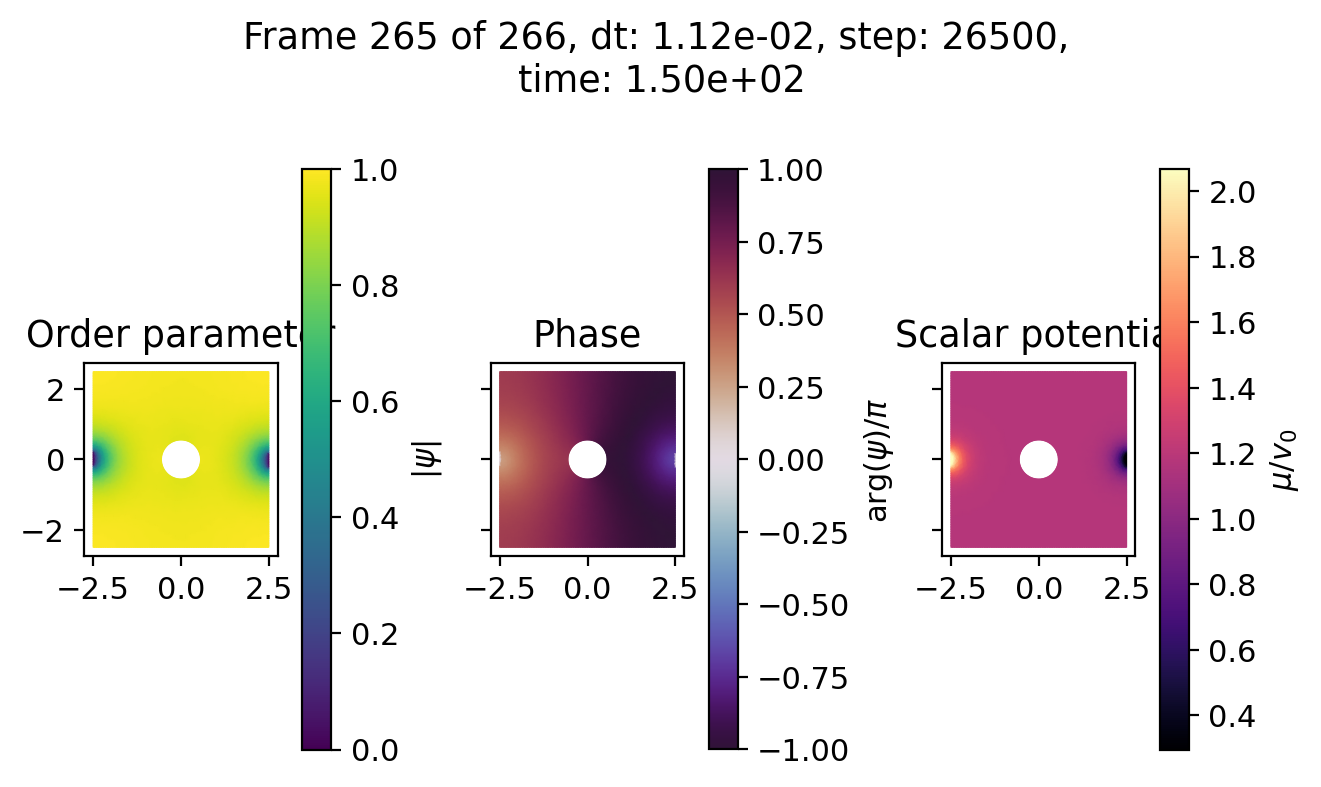

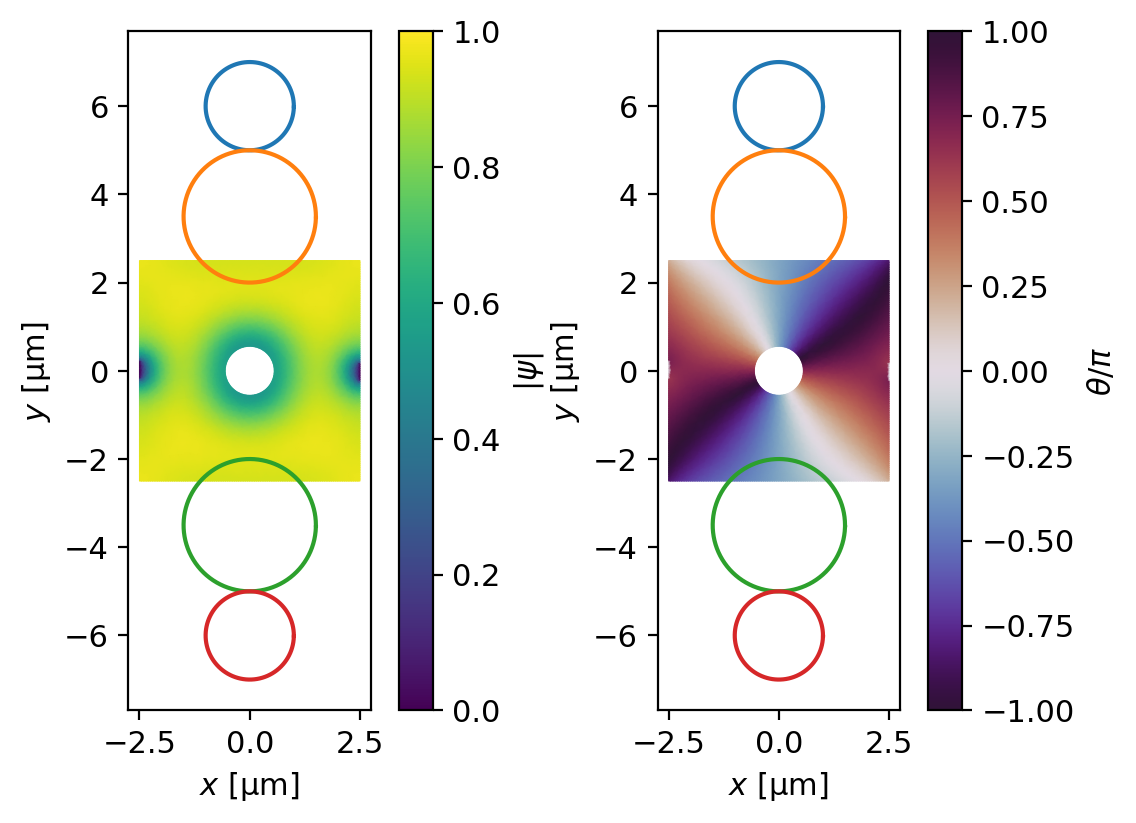

In [14]:
fig, axes = zero_current_solution.plot_order_parameter(figsize=(5.5, 4))

fluxoid_polygons = {
    # name: (circle radius, circle center)
    "Top vortex": (1, (0, 6)),
    "Round hole": (1.5, (0, 3.5)),
    "Square hole": (1.5, (0, -3.5)),
    "Bottom vortex": (1, (0, -6)),
}
for name, (radius, center) in fluxoid_polygons.items():
    polygon = circle(radius, center=center, points=201)
    for ax in axes:
        ax.plot(*polygon.T)

In [15]:
boundary_phases = zero_current_solution.boundary_phases()
for hole in device.holes:
    phases = boundary_phases[hole.name].phases
    fluxoid_from_phase = (phases[-1] - phases[0]) / (2 * np.pi)
    print(f"Total fluxoid for {hole.name!r}: {fluxoid_from_phase:.2f} Phi_0")

Total fluxoid for 'round_hole': 1.98 Phi_0


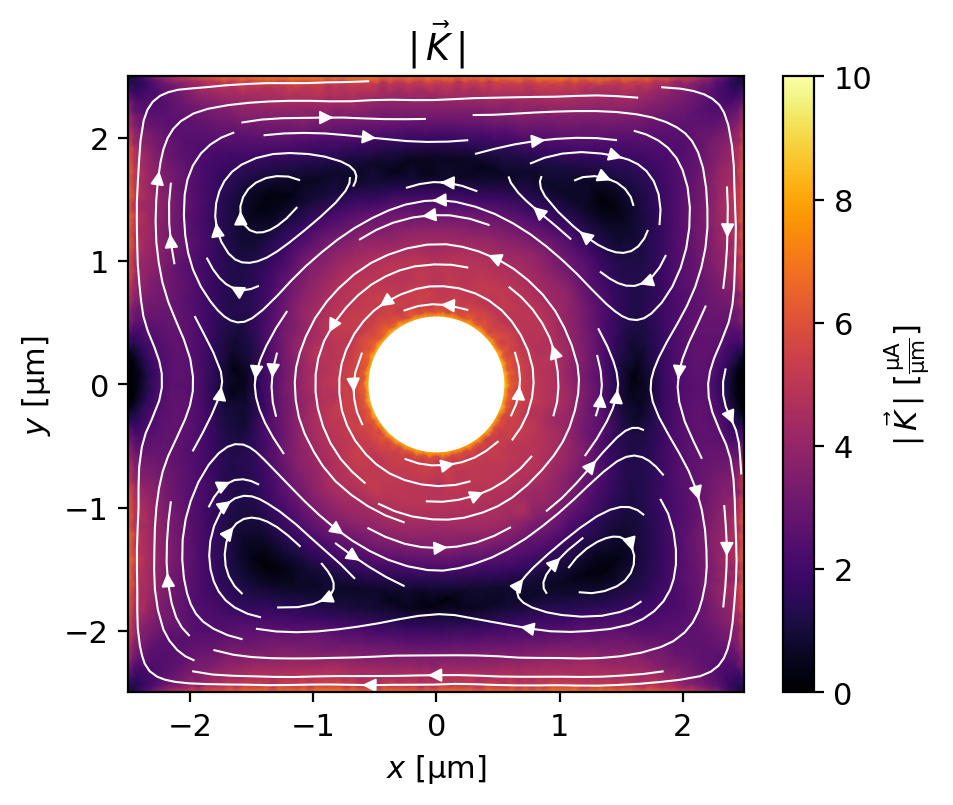

In [16]:
fig, ax = zero_current_solution.plot_currents(min_stream_amp=0.075, vmin=0, vmax=10)

In [17]:
if MAKE_ANIMATIONS:
    zero_current_video = make_video_from_solution(zero_current_solution)
    display(zero_current_video)

##grhrbf

In [18]:
options = tdgl.SolverOptions(
    solve_time=200,
    output_file=os.path.join(tempdir.name, "weak-link.h5"),
    field_units="mT",
    current_units="uA",
)

field_current_solution = tdgl.solve(
    device,
    options,
    applied_vector_potential=0.4,
    terminal_currents=dict(source=12, drain=-12),
    # The seed solution will be used as the initial state of the film.
    seed_solution=zero_current_solution,
)

Simulating: 100%|█████████▉| 200/200 [01:11<00:00,  2.79tau/s ]


In [19]:
if MAKE_ANIMATIONS:
    field_current_video = make_video_from_solution(
        field_current_solution,
        quantities=["order_parameter", "phase", "scalar_potential"],
        figsize=(6.5, 4),
    )
    display(field_current_video)